In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [14]:
df = pd.read_excel(r'InflationExpectations.xlsx', sheet_name = "Clean Data for Python")
expectations_name = '5-10 Year Expectations' #includes preliminary and final numbers
date_time = pd.to_datetime(df.pop('Week'), format ='%Y-%m-%d')

# If there is an ODD number of rows, delete the first row
#    Do this to ensure that the last data point is not lost 
#    See the fourth code box for a longer explanation and example
if (df.shape[0] % 2 == 0):
    df = df.iloc[1: , :]
    print("Removed a Row")
    
n_masked_from_end = 5

# Make Weekly Data into Biweekly data since expectations data is biweekly
df = df.groupby(np.arange(len(df))//2).mean()
date_time = date_time[::2] 

df.tail()

Removed a Row


,Prices Interest,5-10 Year Expectations,Gas Prices,1 Year Inflation Expectations,cereal prices: (United States),egg prices: (United States),cpi: (United States),rent increase: (United States)
126,28.5,3.0,4.410,5.40,23.5,26.0,21.0,63.0
127,34.5,3.0,4.605,5.35,21.5,60.0,67.0,69.0
128,30.0,3.3,4.945,5.30,12.5,24.5,25.0,68.0
129,27.3,3.1,4.915,5.30,19.0,17.5,24.5,91.5
130,21.7,3.2,4.770,5.30,0.0,15.0,60.0,80.0


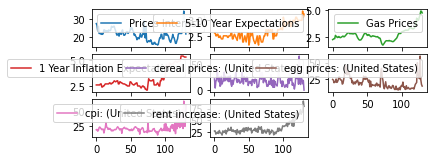

In [15]:
# plot_cols = [expectations_name]
# plot_features = df[plot_cols]
# plot_features.index = date_time
# _ = plot_features.plot(subplots=True)
_ = df.plot(subplots=True, layout= (5,3))

<Figure size 864x432 with 0 Axes>

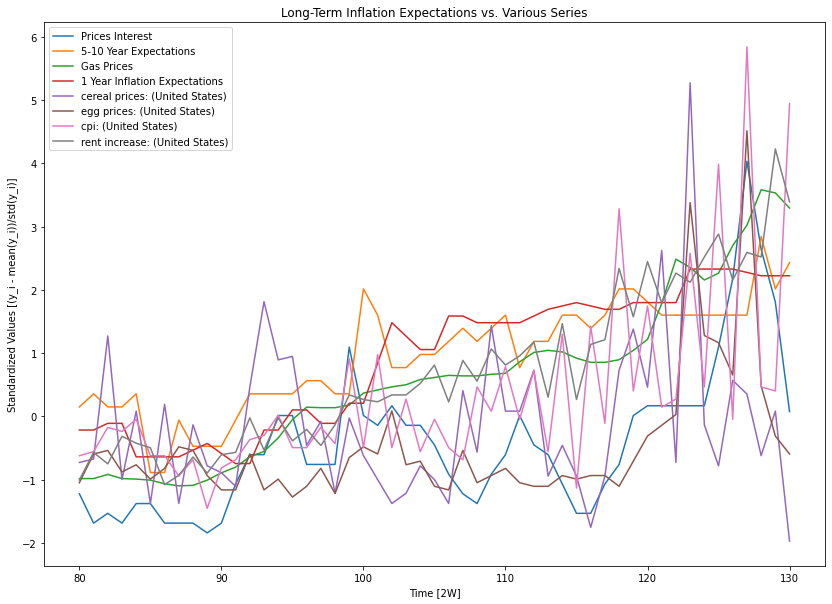

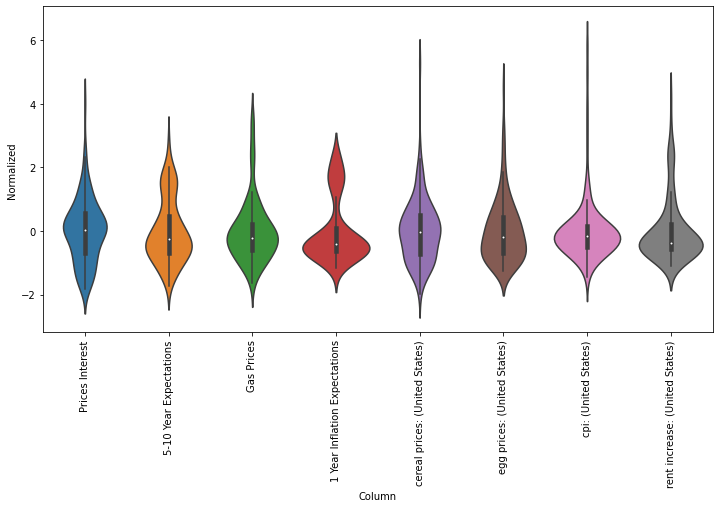

In [4]:
# 70% Train, 20% Validate, 10% Test
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
val_df = df[0:int(n*0.2)]
# Remove the very last data point from training data so that we can forecast it! 
train_df = df[int(n*0.4):n - n_masked_from_end]
test_df = df[int(n*0.2):int(n*0.4)]
num_features = df.shape[1]


# Normalize Data
train_mean = df.mean() #using all of DF instead of just the training data ! not advisable !
train_std = df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


# Visualize distribution of features
df_std = (df - train_mean) / train_std
df_std.tail()

plt.figure(figsize=(12,6))
df_show = df_std[:][80:]
df_show.plot(figsize= (14,10), kind="line")
plt.ylabel("Standardized Values [(y_i - mean(y_i))/std(y_i)]")
plt.xlabel("Time [2W]")
plt.title("Long-Term Inflation Expectations vs. Various Series")
plt.show()

df_std = df_std.melt(var_name='Column', value_name="Normalized")
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation = 90)

In [5]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        # Store raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out label column indices
        self.label_columns = label_columns
        if label_columns is not None: 
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])


In [6]:
# The split_window function 'converts consecutive inputs into a window of inputs and a window of labels'
def split_window(self, features): 
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:,:, self.column_indices[name]] for name in self.label_columns], axis=-1
        )
        
    # Slicing doesn't preserve static shape information 
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [7]:
# Model will provide predictions
def plot_last(self, model=None, plot_col=expectations_name, title = None):
    
    # Get the last window size from the overall data set, which includes data not in the training set
    last_part = df[df.shape[0]-self.total_window_size-n_masked_from_end+1:df.shape[0]-n_masked_from_end+1]
    last_part_standardized = (last_part - train_mean) / train_std
    end_window = tf.stack([np.array(last_part_standardized)])
    inputs, labels = self.split_window(end_window)

    max_n = len(inputs)
    for n in range(max_n):
       
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else: 
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
    
        prediction = 0
        if model is not None:
            predictions = model(inputs)
            prediction = (predictions[0][-1][label_col_index]*train_std[expectations_name]+train_mean[expectations_name]).numpy()
    
    return prediction

WindowGenerator.plot_last = plot_last

In [8]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data = data,
        targets = None,
        sequence_length = self.total_window_size,
        sequence_stride = 1,
        shuffle = True,
        batch_size = 32,)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [9]:
# Access Train, Validation, and Test training data
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [10]:
# Package the training procedure into a callable function for many models
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience = 50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                     patience=patience,
                                                     mode='min')
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                       validation_data=window.val,
                       callbacks=[early_stopping], verbose=0)
    
    return history

In [11]:
# Set up windows for model
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[expectations_name])

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[expectations_name])

conv_window
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['5-10 Year Expectations']

In [18]:
# For each number from the end, run it 30 times
n_trials = 4
n_predictions = 50

# Initialize outputs 
predictions = np.zeros(n_predictions)
errors = np.zeros(n_predictions)
stds = np.zeros(n_predictions)
accuracy = np.zeros(n_predictions)

trial_stds = np.zeros(n_trials)


for n in range(1, n_predictions):
    for i in range(n_trials):
        n_masked_from_end = n
        
        # Define training data to be all rows BEFORE the prediction for EACH prediction
        train_df = df[int(len(df)*0.2):len(df) - n] # note the "-n" here where n \in [1, n_predic]
        train_df = (train_df - train_mean) / train_std
        conv_window.train_df = train_df
        
        # Define model
        model = tf.keras.Sequential([
            tf.keras.layers.Conv1D(filters=256,
                                   kernel_size=(CONV_WIDTH,),
                                   activation='relu'),
            tf.keras.layers.Dense(units=128, activation='relu'),
            tf.keras.layers.Dense(units=64, activation='relu'),
            tf.keras.layers.Dense(units=32, activation='relu'),
            tf.keras.layers.Dense(units=1),
        ])
        
        # Train model
        history = compile_and_fit(model, conv_window)
        IPython.display.clear_output()
        
        # Get prediction 
        predic = conv_window.plot_last(model, title = "CNN")
        
        # Add prediction to list of results and errors
        predictions[n_predictions - n] += predic
        errors[n_predictions - n] += (predic - df[expectations_name][df.shape[0] - n])
        trial_stds[i] = predic
        
    stds[n_predictions - n] = np.std(trial_stds)
    if (predic > (df[expectations_name][df.shape[0] - n] - 2*np.std(trial_stds)) and predic < (df[expectations_name][df.shape[0] - n] + 2*np.std(trial_stds))):
        accuracy[n_predictions - n] = 1


meanList = [x / n_trials for x in predictions]   
errors = [x / n_trials for x in errors]

Squared Error / prediction: 0.013877764052618655
% Within 2 STD: 0.46938775510204084


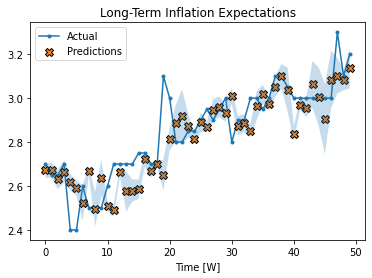

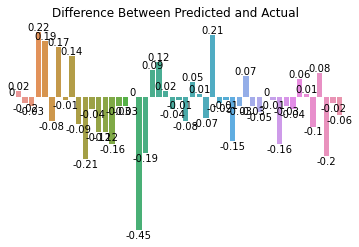

 Standard Deviations of Predictions: [0.01704704 0.01704704 0.02243766 0.02540466 0.0186186  0.01696434
 0.04119927 0.01000079 0.03931771 0.04054151 0.01066037 0.01440079
 0.01125403 0.0457833  0.02539055 0.02199803 0.01715571 0.01656842
 0.00584993 0.0356455  0.02566754 0.04137635 0.06177989 0.02644382
 0.01040236 0.02229741 0.01148274 0.02461648 0.02364049 0.01998335
 0.01775732 0.02230024 0.02076583 0.01508323 0.03301523 0.02159241
 0.01562129 0.02285128 0.02817865 0.04993847 0.01785644 0.01291544
 0.02121536 0.05372326 0.06633521 0.0805964  0.06509682 0.0409376
 0.02318523 0.04590288]


In [19]:
err = np.array(errors)
stds[0] = stds[1]
print(f'Squared Error / prediction: {np.sum(err**2)/n_predictions}')
print(f'% Within 2 STD: {np.sum(accuracy)/(n_predictions-1)}')

indices = np.arange(n_predictions)
meanList[0] = meanList[1] # Get rid of 0 value
plt.plot(indices, df[expectations_name][df.shape[0] - n_predictions:],
                label='Actual', marker='.', zorder=-10)
plt.scatter(indices, meanList, marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)
plt.fill_between(indices,meanList-2*stds,meanList+2*stds,alpha=.25)

plt.xlabel("Time [W]")
plt.title("Long-Term Inflation Expectations")
plt.legend()
plt.show()


errors = [round(n, 2) for n in errors]
ax = sns.barplot(x = np.arange(len(errors)), y=errors)
ax.bar_label(ax.containers[0])
plt.axis('off')
plt.title("Difference Between Predicted and Actual")
plt.show()

print(f' Standard Deviations of Predictions: {stds}')